In [24]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import numba as nb
from numba import cuda

In [25]:
def myseq_with_plotting(pixelsMatrix,mask= None,grayLevels = 256):
    H,W = pixelsMatrix.shape
    size = H*W
    occurencies = [0.0 for _ in range(grayLevels)]
    for row_id,row in enumerate(pixelsMatrix):
        for pixel_id,pixel in enumerate(row):
            if mask is None or mask[row_id][pixel_id]==0:
                occurencies[pixel]+=1
    cdf = [sum(occurencies[:i+1]) for i in range(grayLevels)]
    cdfmin = next((x for x in cdf if x),-1)
    h = [round((cdf[v]-cdfmin)/(size-cdfmin) * (grayLevels-1)) for v in range(grayLevels)]

    for row_id,row in enumerate(pixelsMatrix):
        for pixel_id,pixel in enumerate(row):

            if mask is None or mask[row_id][pixel_id]==0:
                pixelsMatrix[row_id][pixel_id] = h[pixel]
            

    occurrencies_equalized = [0.0 for _ in range(grayLevels)]

    for row_id,row in enumerate(pixelsMatrix):
        for pixel_id,pixel in enumerate(row):
            if mask is None or mask[row_id][pixel_id]==0:


                occurrencies_equalized[pixel]+=1


    plt.bar(range(grayLevels),occurrencies_equalized,label = 'equalized')
    plt.bar(range(grayLevels),occurencies,label = 'original')
    plt.legend()
    return Image.fromarray(pixelsMatrix)


In [26]:
def sequential(pixelMatrix,mask=None,grayLevels = 256) -> np.ndarray:
    H,W = pixelMatrix.shape
    assert mask is None or mask.shape==pixelMatrix.shape,"Invalid mask size"
    size = H*W
    occurencies = [0.0 for _ in range(grayLevels)]
    for row_id,row in enumerate(pixelMatrix):
        for pixel_id,pixel in enumerate(row):
            if mask is None or mask[row_id][pixel_id]==0:
                occurencies[pixel]+=1

    cdf = [int(sum(occurencies[:i+1])) for i in range(grayLevels)]
    cdfmin = next((x for x in cdf if x),-1)

    h = [round((cdf[v]-cdfmin)/(size-cdfmin) * (grayLevels-1)) for v in range(grayLevels)]

    for row_id,row in enumerate(pixelsMatrix):
        for pixel_id,pixel in enumerate(row):
            if mask is None or mask[row_id][pixel_id]==0:
                pixelsMatrix[row_id][pixel_id] = h[pixel]

    return pixelsMatrix
    


In [27]:
@nb.jit(fastmath=True,nopython=True)
def generate_dummy_mask(matrix:np.ndarray,threshold = 200):
    mask = np.copy(matrix)
    for row_id,row in enumerate(mask):
        for pixel_id,pixel in enumerate(row):
            mask[row_id][pixel_id] = pixel>threshold
    return mask


def cuda_generate_dummy_mask(matrix:np.ndarray,threshold = 200):
    mask = np.copy(matrix)
    mask = mask.astype(np.int32)

    mask_d = cuda.to_device(mask)
    H,W = matrix.shape
    blockdim = (32, 32)
    griddim = (H // blockdim[0] + 1,W // blockdim[1] + 1)

    cuda_mask_kernel[griddim,blockdim](mask_d,nb.int32(threshold))
    mask = np.array(mask_d)
    del mask_d
    return mask
    

@cuda.jit()
def cuda_mask_kernel(mask,threshold_d):
    x,y = cuda.grid(2)
    mask[y][x] = mask[y][x]>threshold_d




In [28]:
woman = Image.open('huge_image.png').convert('L')
woman = np.array(woman)

In [29]:
%%timeit -r 5 -n 5
mask = generate_dummy_mask(woman,50)

The slowest run took 37.03 times longer than the fastest. This could mean that an intermediate result is being cached.
8.77 ms ± 15.2 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [30]:
# %%timeit -r 5 -n 5

# mask = cuda_generate_dummy_mask(woman,50)


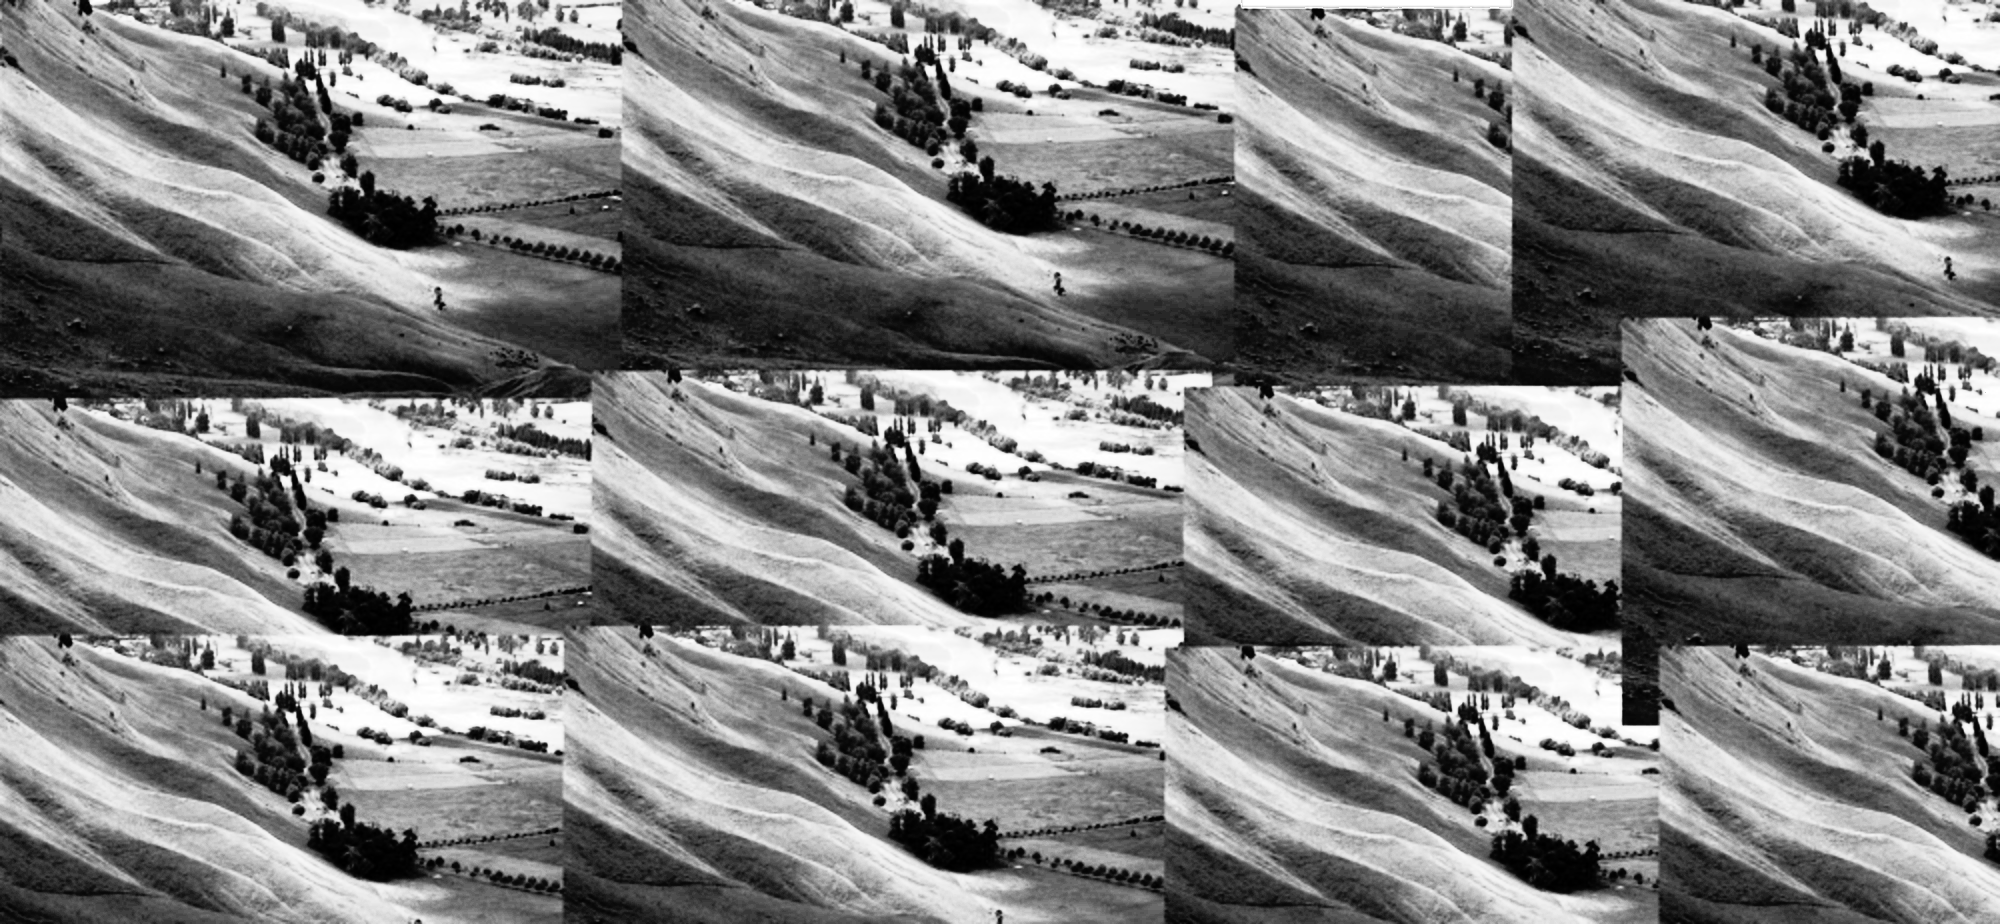

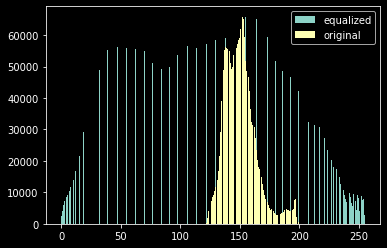

In [31]:

myseq_with_plotting(woman,mask)

In [32]:
import numba as  nb
import numpy as np
from numba import cuda

@cuda.jit(fastmath = True)
def countOccurencies(pixelsMatrix,occurencies,mask):
    x,y = cuda.grid(2)
    if x>=pixelsMatrix.shape[0] or y>=pixelsMatrix.shape[1]:
        return
    if mask[y][x] == 1:
        return
    cuda.atomic.add(occurencies,pixelsMatrix[y][x],1)

@cuda.jit(fastmath = True)
def calcCDF(occurencies_d,cdf):  # sourcery skip: sum-comprehension
    acc = 0
    for i in range(cuda.grid(1)+1):
        acc+=occurencies_d[i]
    cdf[cuda.grid(1)] = acc

@cuda.jit(fastmath = True)
def calcH(h,cdf_d,cdfmin_d,size_d,grayLevels_d):
    nominator = (cdf_d[cuda.grid(1)]-nb.int32(cdfmin_d))

    denominator = (size_d-cdfmin_d)
    multiplier = (grayLevels_d-1)
    result = round(nominator/denominator*multiplier)

    h[cuda.grid(1)] = result
    # print("XD")

@cuda.jit(fastmath = True)
def changeOriginalValues(h_d,pixelsMatrix,mask):
    x,y = cuda.grid(2)
    if x>=pixelsMatrix.shape[0] or y>=pixelsMatrix.shape[1]:
        return
    if mask[y][x] == 1:
        return
    pixelsMatrix[y][x] = nb.int32( h_d[pixelsMatrix[y][x]] )





def parallel(pixelsMatrix,mask,grayLevels = 256):
    H,W = pixelsMatrix.shape
    blockdim = (32, 32)
    mask_d = cuda.to_device(mask)

    griddim = (H // blockdim[0] + 1,W // blockdim[1] + 1)
    occurencies = np.zeros(grayLevels,np.int32)
    pixelsMatrix = pixelsMatrix.astype(np.int32)
    pixelsMatrix_d = cuda.to_device(pixelsMatrix)
    del pixelsMatrix
    occurencies_d = cuda.to_device(occurencies)
    countOccurencies[griddim,blockdim](pixelsMatrix_d,occurencies_d,mask_d)
    cdf = np.zeros(grayLevels,np.int32)
    cdf_d = cuda.to_device(cdf)
    threadsperblock = 32
    blockspergrid = (grayLevels + (threadsperblock - 1)) // threadsperblock
    calcCDF[threadsperblock,blockspergrid](occurencies_d,cdf_d)

    del occurencies_d

    cdfmin = next((x for x in cdf_d if x),-1)

    h = np.zeros(grayLevels,np.int32)
    h_d = cuda.to_device(h)
    

    calcH[threadsperblock,blockspergrid](h_d,cdf_d,nb.int32(cdfmin),nb.int32(H*W),nb.int32(grayLevels))
    del cdfmin
    del cdf_d

    changeOriginalValues[griddim,blockdim](h_d,pixelsMatrix_d,mask_d)
    
    del h_d


    return pixelsMatrix_d




In [33]:
hugeIMG = Image.open('huge_image.png').convert('L')
pixelsMatrix = np.array(hugeIMG)
mask = generate_dummy_mask(pixelsMatrix)

In [34]:
%%timeit -r 5 -n 10

xd = parallel(pixelsMatrix,mask)

CudaAPIError: [700] Call to cuMemAlloc results in UNKNOWN_CUDA_ERROR

In [ ]:
%%timeit -r 5 -n 10


sequ = sequential(pixelsMatrix,mask)

In [ ]:
einstein = Image.open('einstein.png').convert('L')
pixelsMatrix = np.array(einstein)
mask = generate_dummy_mask(pixelsMatrix)


In [ ]:
%%timeit -r 5 -n 10



sequ = parallel(pixelsMatrix,mask)

In [ ]:
%%timeit -r 5 -n 10


sequ = sequential(pixelsMatrix,mask)

In [ ]:
stars = Image.open('bigbig.png').convert('L')
pixelsMatrix = np.array(stars)
mask = generate_dummy_mask(pixelsMatrix)


In [ ]:
%%timeit -r 2 -n 5

sequ = parallel(pixelsMatrix,mask)

In [ ]:
%%timeit -r 2 -n 10
sequ = sequential(pixelsMatrix,mask)